# Visualize the synthesis filters of trained models

To load pretrained checkpoints, clone this repo: https://huggingface.co/yiboyang/shallow-ntc-checkpoints/ and move it into a subdir called `checkpoints`. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/yiboyang/projects/code_releases/shallow-ntc


In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import tensorflow as tf
import tensorflow_compression as tfc
import numpy as np
from absl import logging
from ml_collections import ConfigDict

import json

In [5]:
import matplotlib.pyplot as plt

In [6]:
import mediapy
from common.data_lib import get_dataset

In [7]:
from nbu import load_json, dump_json, show_fimgs
import os

In [26]:
from mshyper.models import Model
model_cls = Model

In [9]:
from common.eval_lib import load_latest_ckpt

In [34]:
import glob
workdir = glob.glob('checkpoints/jpegl/wid=*lambda=0.00125*')[0]
print(workdir)
model = load_latest_ckpt(workdir, model_cls=model_cls)

checkpoints/jpegl/wid=3-mshyper-analysis=ElicAnalysis-rd_lambda=0.00125-latent_ch=320-uq_method=unoise


In [11]:
test_ds = get_dataset("kodak", split="validation", batchsize=1, patchsize=None)
test_xs = list(test_ds)

In [12]:
### Quick eval on full kodak

In [17]:
if True:
  metrics_list = list(model.evaluate(test_ds))
  # from common.train_lib import Metrics
  # agg_metrics = Metrics.merge_metrics(metrics_list)
  avg_bpp = np.mean([m.scalars['bpp'] for m in metrics_list])
  avg_psnr = np.mean([m.scalars['psnr'] for m in metrics_list])
else:
  avg_bpp, avg_psnr = None, None

In [18]:
avg_bpp, avg_psnr

(0.21578039, 28.692709)

## Order latent channels by avg energy

In [12]:
from common.data_lib import floats_to_pixels

In [13]:
# Get a small batch of images to compute latent coefficients
test_xs = list(test_ds)
xs = tf.concat(test_xs[4:8], axis=0)

In [14]:
xs.shape

TensorShape([4, 512, 768, 3])

In [15]:
ys = model._analysis(xs)

In [16]:
energies = tf.reduce_mean(tf.math.square(ys), axis=[0, 1, 2]).numpy()

<BarContainer object of 320 artists>

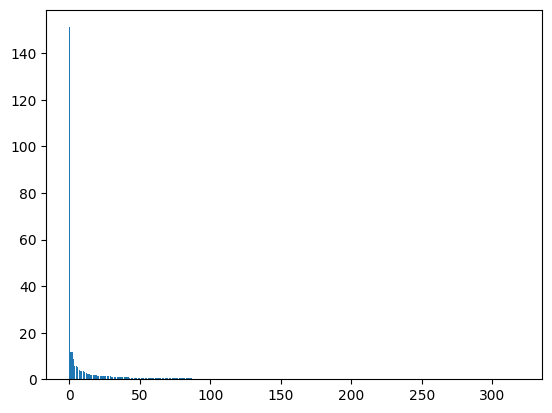

In [21]:
C = len(energies)
plt.bar(np.arange(C), sorted(energies, reverse=True))

In [22]:
argsort = np.argsort(energies)
top_channels = argsort[::-1]

In [23]:
max_coeffs = tf.reduce_max(tf.math.abs(ys), axis=[0, 1, 2]).numpy()

In [24]:
max_coeffs[top_channels[:8]]

array([34.692154, 23.238651, 22.5865  , 20.475782, 16.303547, 20.084831,
       10.592758, 15.004705], dtype=float32)

## Visualize the "basis vectors" of the decoder, as in Duan 2022.
Here we regard the decoder as a linear (affine) transform, g(y) = Ty + g(0), which means we can obtain the ith column of T by evaluatinig g at the ith standard basis vector e_i in the coefficients space (and subtracting g(0)).



### Use ei with unit spatial dimension, which decodes to 16x16 patches

#### Get the affine offset g(0), which doesn't really look like anything (or I might be visualizing it the wrong way)

In [28]:
g0 = model._synthesis(np.zeros([1, 1, 1, C], dtype='float32'))

In [29]:
print(g0.shape)
print(g0[0, :2, :2])

(1, 16, 16, 3)
tf.Tensor(
[[[-0.00738965 -0.04296004 -0.08145567]
  [-0.00738965 -0.04296004 -0.08145567]]

 [[-0.00738965 -0.04296004 -0.08145567]
  [-0.00738965 -0.04296004 -0.08145567]]], shape=(2, 2, 3), dtype=float32)


In [35]:
def normalize_01(x):
  if isinstance(x, tf.Tensor):
    x = x.numpy()
  min_x = np.min(x)
  max_x = np.max(x)
  return (x - min_x) / (max_x - min_x)

g0_vis =  normalize_01(g0)
# g0_vis = tf.saturate_cast(normalize_01(g0) * 255, 'uint8') # mediapy does this conversion automatically
mediapy.show_images(g0_vis, height=64)

""


In [36]:
show_fimgs(g0, height=64)

""


#### Calculate and visualize g(e_i), which also doesn't look like much

In [37]:
g_eis = [None] * C

for i in range(C):
  ei = np.zeros([1, 1, 1, C], dtype='float32')
  # ei[0, 0, 0, i] = 20.0
  ei[0, 0, 0, i] = 1.0
  g_ei = model._synthesis(ei)  # [1, 16, 16, 3]
  g_eis[i] = g_ei[0]
  
g_eis = np.array(g_eis)

In [38]:
g_eis.shape

(320, 16, 16, 3)

In [39]:
show_fimgs(g_eis[top_channels[:10]], height=32)
# mediapy.show_images(normalize_01(g_eis[top_channels[:10]]), height=64)

,,,,,,,,,


#### However, g(e_i) - g(0) does look interesting and resemble the filters from Duan 2022, after normalization

In [40]:
show_fimgs((g_eis[top_channels[:10]] - g0), columns=32, height=32)

,,,,,,,,,


In [41]:
mediapy.show_images(normalize_01(g_eis[top_channels[:10]] - g0), columns=32, height=32)

,,,,,,,,,


In [42]:
mediapy.show_images(normalize_01(g_eis[top_channels[:64]] - g0), columns=32, height=32)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Now do the procedure from Duan 2022 of decoding the scaled standard basis, i.e., g(k * ei) for filter k = 1, ... N; here I order the channels by decreasing avg energy instead of bit rate for simplicity. Also subtract g0 from g(k * ei), which gives the same result as scaling the ith basis T(e_i) by k, since we're now using a linear map.

In [44]:
bases = []
argsort = np.argsort(energies)
top_channels = argsort[::-1]
N = 100
for i in top_channels[:N]: # order by decreasing avg energy
  ei = np.zeros([1, 1, 1, C], dtype='float32')
  ei[0, 0, 0, i] = 30.0
  bi = model._synthesis(ei) - g0
  bi = floats_to_pixels(bi, training=False)
  bases.append(bi[0])

mediapy.show_images(bases, columns=32, height=32)

### A lot of these filters are sparse, esp at low bit-rates, suggesting they can be pruned for further computation savings

### Now Use ei with 2x2 spatial dimension, with only its top-left pixel "active". 




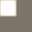
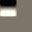
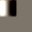
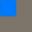
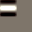
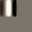
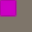
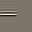
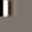
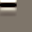
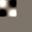
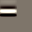
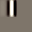
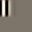
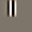
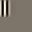
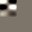
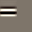
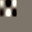
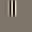
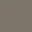
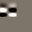
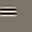
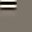
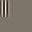
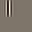
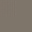
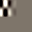
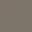
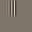
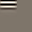
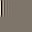
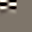
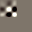
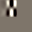
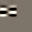
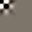
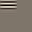
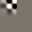
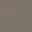
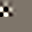
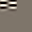
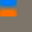
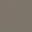
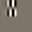
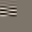
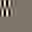
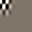
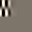
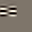
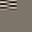
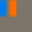
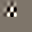
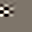
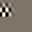
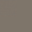
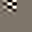
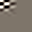
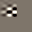
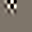
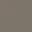
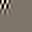
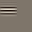
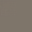
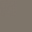
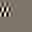
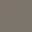
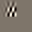
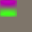
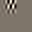
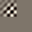
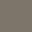
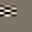
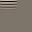
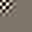
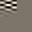
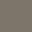
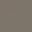
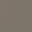
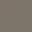
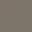
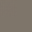
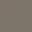
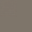
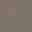
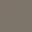
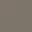
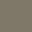
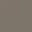
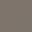
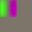
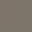
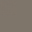
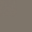
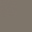
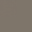
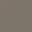
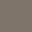
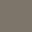
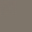

In [45]:
bases = []
argsort = np.argsort(energies)
top_channels = argsort[::-1]
N = 100
for i in top_channels[:N]:
  ei = np.zeros([1, 2, 2, C], dtype='float32')
  ei[0, 0, 0, i] = 30.0
  bi = model._synthesis(ei)
  bi = floats_to_pixels(bi, training=False)
  bases.append(bi[0])

mediapy.show_images(bases, columns=32, height=32)

## Compute Jacobians of the synthesis transform near 0; should be the same as before for an affine synthesis.

In [46]:
y = tf.zeros([1, 1, 1, 320], dtype='float32')

with tf.GradientTape(persistent=True) as tape:
  tape.watch(y)
  xhat = model._synthesis(y)

xhat.shape

TensorShape([1, 16, 16, 3])

In [47]:
jac = tape.jacobian(xhat, y)

In [48]:
jac.shape

TensorShape([1, 16, 16, 3, 1, 1, 1, 320])

In [49]:
jac = tf.reshape(jac, [16, 16, 3, C])
jac = tf.transpose(jac, perm=[3, 0, 1, 2])
jac.shape

TensorShape([320, 16, 16, 3])

In [50]:
jac_vis = jac * 30.0  # also need to scale this to make the visualization look interesting
show_fimgs([jac_vis[i] for i in top_channels[:64]], columns=32, height=32)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
